# Simple regression with TensorFlow

Runs leave-one-out cross validation (site by site)

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeaveOneGroupOut

In [24]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
tf.random.set_seed(42)


2.13.1


In [25]:
from keras import Sequential
from keras import models
from keras import layers

In [26]:
dat = pd.read_csv("./rbfs/phi_short_reduce.csv")
dat.head()
#X = np.load("./rbfs/phi_reduce.npy")
#y = np.load("./rbfs/y.npy")

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,210,211,212,213,214,215,216,y,site,date
0,0,1.000000,0.933712,0.760067,0.539408,0.333740,0.180022,0.084658,0.034709,0.012406,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031,2005,2023-01-08
1,1,0.999728,0.941552,0.773095,0.553410,0.345372,0.187912,0.089135,0.036861,0.013290,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.032,2005,2023-01-08
2,2,0.998914,0.948942,0.785919,0.567468,0.357216,0.196041,0.093797,0.039125,0.014228,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030,2005,2023-01-08
3,3,0.997558,0.955871,0.798521,0.581567,0.369266,0.204411,0.098650,0.041506,0.015225,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031,2005,2023-01-08
4,4,0.995663,0.962327,0.810885,0.595692,0.381514,0.213022,0.103697,0.044008,0.016283,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.031,2005,2023-01-08


In [27]:
dat.site

0       2005
1       2005
2       2005
3       2005
4       2005
        ... 
1139    4002
1140    4002
1141    4002
1142    4002
1143    4002
Name: site, Length: 1144, dtype: int64

In [28]:
dat2 = dat[dat['date'] == "2023-01-01"]
dat2.shape

(0, 221)

In [29]:
dat2 = dat2.groupby('site')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


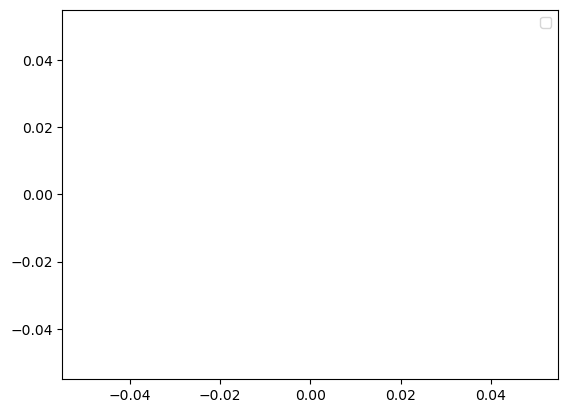

In [30]:
# Plot
fig, ax = plt.subplots()

ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in dat2:
    ax.plot(group.y, marker='o', linestyle='', ms=12, label=name)
ax.legend()

plt.show()

In [31]:
X = dat.iloc[:, 1:218]
y = dat['y']

In [32]:
groups = dat['site']
logo = LeaveOneGroupOut()
logo.get_n_splits(X, y, groups)

8

In [33]:
groups

0       2005
1       2005
2       2005
3       2005
4       2005
        ... 
1139    4002
1140    4002
1141    4002
1142    4002
1143    4002
Name: site, Length: 1144, dtype: int64

In [34]:
mygrps = groups.unique()
n_grps = len(mygrps)

In [35]:
def make_model(n_feat):
    model = models.Sequential([
        layers.Dense(512, activation='relu', input_shape=(n_feat,)),
        layers.Dense(512, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='linear')
        ], name="Initial_model")
    return model

In [36]:
model = make_model(100)
model.summary()

Model: "Initial_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_54 (Dense)            (None, 256)               25856     
                                                                 
 dense_55 (Dense)            (None, 128)               32896     
                                                                 
 dense_56 (Dense)            (None, 1)                 129       
                                                                 
Total params: 58881 (230.00 KB)
Trainable params: 58881 (230.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Cross-validation loop

In [37]:
# Model set up
initial_learning_rate = 0.00001
optimizer = keras.optimizers.legacy.Adam(learning_rate=initial_learning_rate)
n_epochs = 20
batch_size = 1024

In [38]:
my_mae = np.empty(n_grps)
my_y_true = []
my_y_pred = []

In [39]:
for i, (train_index, test_index) in enumerate(logo.split(X, y, groups)):
    print(f"Fold {i}:")
    print(f"Site {mygrps[i]}:")
    #print(f"  Train: index={train_index}, group={groups[train_index]}")
    #print(f"  Test:  index={test_index}, group={groups[test_index]}")

    # Split out data
    X_train = X.iloc[train_index, :]
    print(X_train.shape)
    y_train = y[train_index]
    n_feat = X_train.shape[1]
    
    X_test = X.iloc[test_index, :]
    print(X_test.shape)
    y_test = y[test_index]

    # Build model
    model = make_model(n_feat)

    # Compile model
    model.compile(loss='mae', metrics=['mae', 'mse'], optimizer=optimizer)

    # Train model
    history=model.fit(X_train, y_train, epochs=n_epochs, 
                  batch_size=batch_size, verbose=1, 
                  validation_split=0.2)
    
    ## Predict for test set
    y_test_pred = model.predict(X_test)
    my_mae[i] = mean_absolute_error(y_test, y_test_pred)
    print(f"MAE: {my_mae[i]}")
    
    my_y_true.append(y_test.to_numpy())
    my_y_pred.append(y_test_pred)




Fold 0:
Site 2005:
(1002, 217)
(142, 217)
Epoch 1/20
1/1 [==============================] - 0s 250ms/step - loss: 0.1670 - mae: 0.1670 - mse: 0.0377 - val_loss: 0.1413 - val_mae: 0.1413 - val_mse: 0.0277
Epoch 2/20
1/1 [==============================] - 0s 17ms/step - loss: 0.1645 - mae: 0.1645 - mse: 0.0367 - val_loss: 0.1392 - val_mae: 0.1392 - val_mse: 0.0270
Epoch 3/20
1/1 [==============================] - 0s 18ms/step - loss: 0.1621 - mae: 0.1621 - mse: 0.0357 - val_loss: 0.1371 - val_mae: 0.1371 - val_mse: 0.0264
Epoch 4/20
1/1 [==============================] - 0s 18ms/step - loss: 0.1597 - mae: 0.1597 - mse: 0.0348 - val_loss: 0.1351 - val_mae: 0.1351 - val_mse: 0.0257
Epoch 5/20
1/1 [==============================] - 0s 17ms/step - loss: 0.1575 - mae: 0.1575 - mse: 0.0338 - val_loss: 0.1332 - val_mae: 0.1332 - val_mse: 0.0251
Epoch 6/20
1/1 [==============================] - 0s 17ms/step - loss: 0.1552 - mae: 0.1552 - mse: 0.0329 - val_loss: 0.1314 - val_mae: 0.1314 - val_mse

In [40]:
my_y_pred

[array([[-0.23894194],
        [-0.24828173],
        [-0.25496376],
        [-0.2578991 ],
        [-0.26043963],
        [-0.2608865 ],
        [-0.2547065 ],
        [-0.24549808],
        [-0.23995882],
        [-0.23676975],
        [-0.23445646],
        [-0.23128544],
        [-0.2265387 ],
        [-0.22062628],
        [-0.21427538],
        [-0.20707133],
        [-0.2038247 ],
        [-0.20630975],
        [-0.20972861],
        [-0.20923552],
        [-0.20566481],
        [-0.20293424],
        [-0.20202823],
        [-0.20425177],
        [-0.20634429],
        [-0.21147673],
        [-0.21221945],
        [-0.21111816],
        [-0.2043742 ],
        [-0.19501258],
        [-0.18603548],
        [-0.18196063],
        [-0.17871244],
        [-0.17500095],
        [-0.17431243],
        [-0.17143567],
        [-0.16340749],
        [-0.1534204 ],
        [-0.14747119],
        [-0.14666203],
        [-0.14780986],
        [-0.15124032],
        [-0.15725929],
        [-0

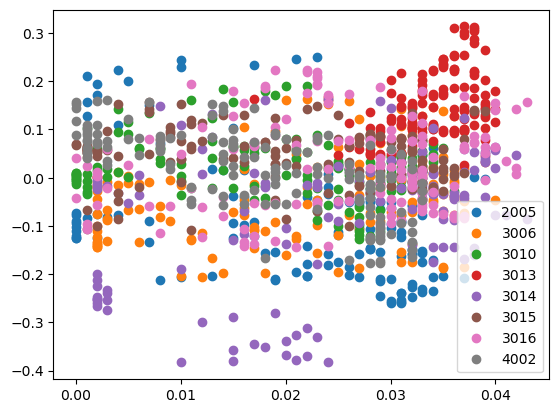

In [41]:
plt.figure()
for i in range(len(mygrps)):
    plt.plot(my_y_true[i], my_y_pred[i], 'o', label = mygrps[i])

plt.legend()
plt.show()

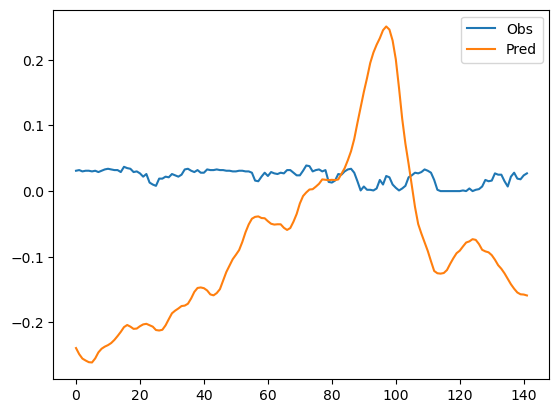

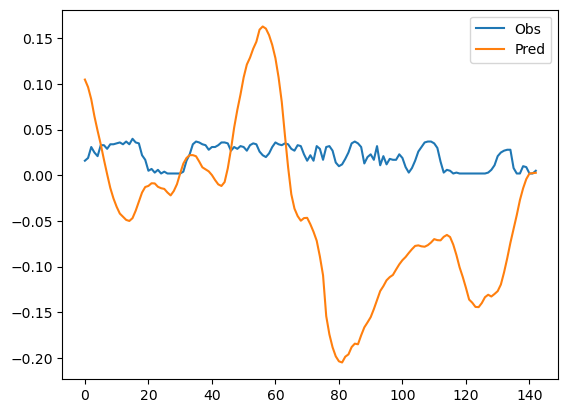

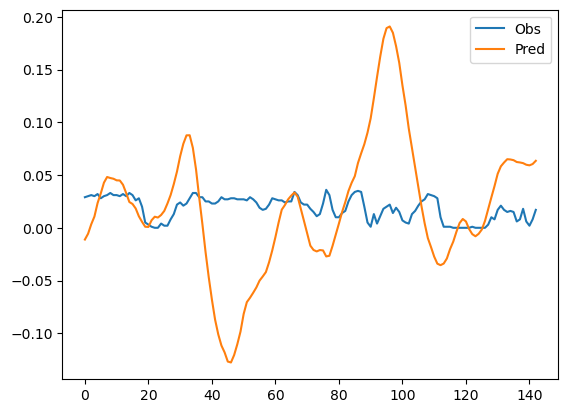

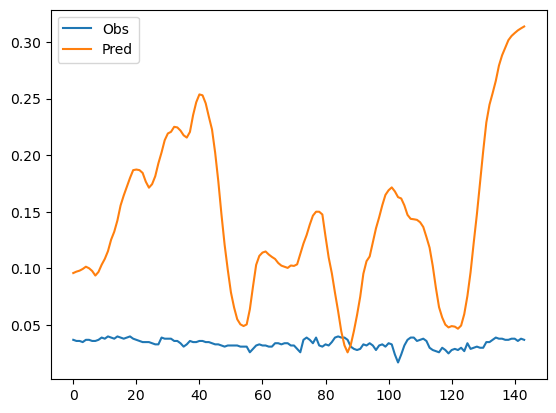

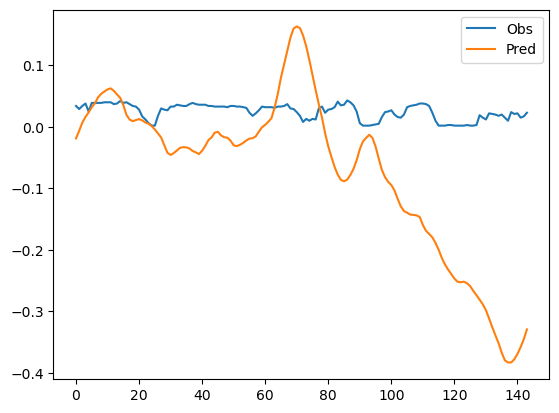

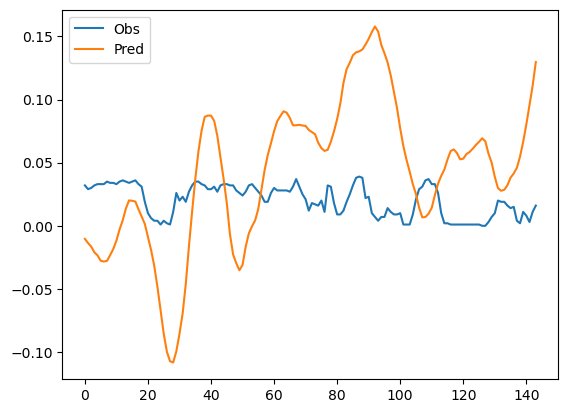

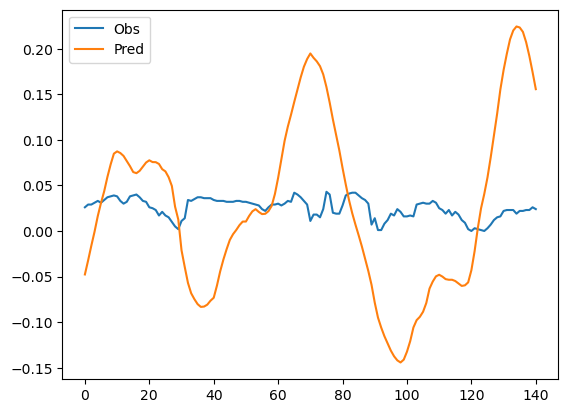

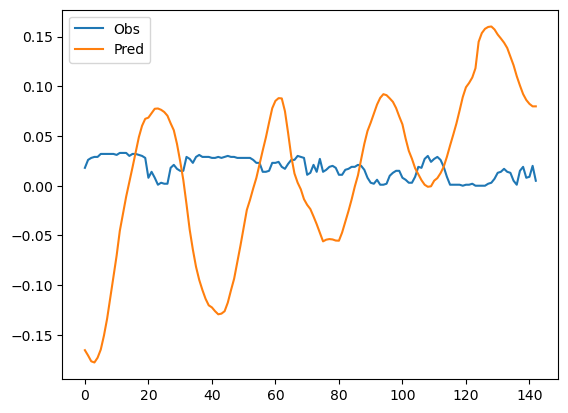

In [42]:
for i in range(len(mygrps)):
    plt.plot(my_y_true[i], label = "Obs")
    plt.plot(my_y_pred[i], label = "Pred")
    plt.legend()
    plt.show()